### EE 421/521 Image Processing - Spring 2020-21

## Project 12 - Image Coding

#### Submission deadline: 24 May 2021

In this project, you will implement the following:

1. Vector Huffman coding

**This project will be graded for both EE 421 (HW8) and EE 521 (HW11) students.**

*Copyright (c) 2021 by Arif Tanju Erdem*

************************************
Neva Yaren Bulut
************************************

In [2]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib as mpl
import matplotlib.pyplot as plt

# array operations
import numpy as np

# mathematical calculations
import math

# data frame operations
import pandas as pd

In [3]:
# my function to convert to lumincance, round to nearest integer, 
# truncate to range [0, 255], and then set data

def my_imgLuminance(imgRGB):
    
    # make sure it is a color image
    dim_img = imgRGB.shape[2]    
    assert dim_img >= 3
    
    # get the luminance data
    if dim_img == 3:
        imgLum = color.rgb2gray(imgRGB)
    else:
        # ignore the alpha channel
        imgLum = color.rgb2gray(imgRGB[:,:,0:3])

    imgLum = np.round(imgLum * 255, 0)
    imgLum = np.minimum(imgLum, 255)
    imgLum = np.maximum(imgLum, 0)
    imgLum = imgLum.astype('uint8')
    
    return imgLum

# end of function

In [4]:
# calculate the entropy of a pdf
def my_Entropy(pdf):
    
    assert pdf.ndim == 1
    size = pdf.size
        
    entropy = 0.0
    for i in range(size):
        val = pdf[i]
        if val:
            entropy += - val * math.log2(val)

    return entropy

# end of my function

In [5]:
# my function for obtaining a Huffman code for a given set of symbols
def my_Huffman(df):
    
    print("\nInput Source:\n", df)  
    
    # 1. sort the symbols in decreasing probabilities
    df.sort_values(by=['probabilities'], ascending=False, inplace=True)
    
    # 2. if more than 2 symbols, merge the last two symbols to obtain a reduced source
    # last code of the reduced source
    last_code = ''
    length = df.shape[0]
    if length > 2:
        # copy the source except the last symbol
        df_merged = df[:-1].copy(deep=True)
        # combine the last two symbols
        df_merged.iloc[-1, 1] += df.iloc[-1, 1]
        # combine the last two probabilities
        df_merged.iloc[-1, 2] += df.iloc[-1, 2]
        # re-number the symbols from 0 to length-1
        for i in range(length-1):
            df_merged.iloc[i,0] = i
            
        # 3. find the Huffman code for the reduced source
        my_Huffman(df_merged)   

        # 4. copy the codewords from the reduced source
        for i in range(length-2):
            df.iloc[i, 3] = df_merged.iloc[i, 3]
        last_code = df_merged.iloc[length-2, 3]

    # 4. add 0 and 1 two the last two codewords, respectively 
    df.iloc[-2, 3] = last_code + '0'
    df.iloc[-1, 3] = last_code + '1'
    
    # 5. unsort the symbols
    df.sort_values(by=['order'], ascending=True, inplace=True)

    print("\nReturned Codes:\n", df)  
        
    return

# end of my function


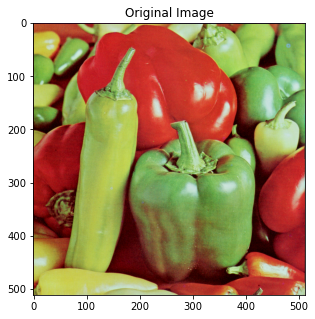

In [6]:
# set image folder
image_folder = r'D:\yeni\Dersler\EE421-imageprocessing\images'

# read a 512x512 image file and correct color order
image_file = r'/peppers.png'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

plt.figure(figsize=(5,5))
plt.subplot(111), plt.imshow(imgRGB)
#plt.xticks([]), plt.yticks([])
plt.title('Original Image')
plt.show()
plt.close()


Image pdf (entropy: 2.72)


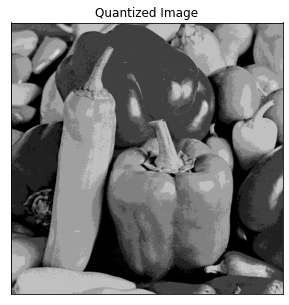

In [7]:
# STEP 1 Quantize the image with 32 so that there are only 8 intensity levels

# ADD YOUR CODE HERE

# img: image with a single color band
# nBit: number of most significant bits to retain
def my_Histogram(img, nBit):
    
    # calculate the number of levels corresponding to the number of bits retained
    nLevel = 2**nBit

    # quantize the image to the specified number of bits
    valMax = 0
    for i in range(8-nBit,8):
        valMax += 2**i
    
    # retain only the most significant nBit bits
    imgQuan = img & valMax

    # calculate the histogram of the quantized image
    hist = np.zeros((nLevel,), dtype=int)
    valMin = 2**(8-nBit)
    for n in range(nLevel):
        hist[n] = np.count_nonzero(imgQuan==n*valMin)
    
    # return the histogram, quantized image, and number of levels
    return hist, imgQuan, nLevel

# display the quantized image

# get a luminance image
if imgRGB.ndim >= 3:
    # calculate the luminance image
    imgLum = my_imgLuminance(imgRGB)
else:
    imgLum = imgRGB

# calculate the histogram
nBit = 3 # 8 bit intensity level
histLum, imgLumQuan, numLevel = my_Histogram(imgLum, nBit)

# calculate the pdf
pdfLum = histLum / histLum.sum()

# calculate the entropy
entLum = my_Entropy(pdfLum)

print('Image pdf (entropy: {:.2f})'.format(entLum))

plt.figure(figsize=(10,5))
plt.subplot(111), plt.imshow(imgLumQuan, cmap='gray', vmin=0, vmax=255)
plt.title('Quantized Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.close()

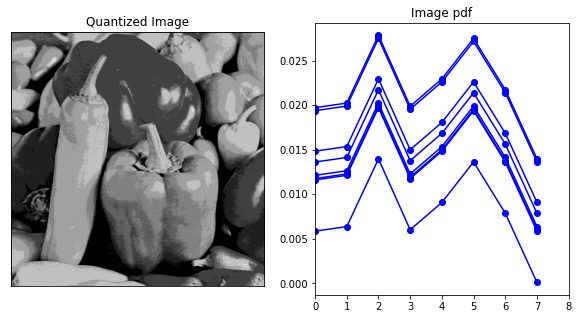

In [8]:
# STEP 2 Define a vector source by combining two consecutive pixels
#        and calculate the probabilities of these vector symbols

# ADD YOUR CODE HERE

order = []
symbols = []
probabilities = []
codewords = []

newHist = np.empty([8, 8])
for i in range(0,8):
    for j in range(0,8):
        newHist[i,j] = histLum[i]+histLum[j]

        
newPdf = newHist / newHist.sum()

# notes:
# since each pixel has 8 intensity levels, there will be 8x8 = 64 symbols in the vector source.
# the symbols for the vector source could be represented as "aa, ab, ac, ..., hf, fg, hh."
# there are a total of 512*512/2 = 131,072 sample vectors in the input image to calculate the histogram

# calculate the histogram of the vector symbols

# obtain the pdf by normalizing the histogram

# plot the pdf of this vector source
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(imgLumQuan, cmap='gray', vmin=0, vmax=255)
plt.title('Quantized Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.plot(newPdf, color = 'b', marker = 'o')
plt.xlim([0,numLevel])
plt.title('Image pdf')
plt.show()
plt.close()

In [29]:
# STEP 3.a Calculate the entropy of the scalar source

# ADD YOUR CODE HERE

# print the value of the entropy of the scalar source

# calculate the pdf
pdfLum = histLum / histLum.sum()

# calculate the entropy
entLum = my_Entropy(pdfLum)

print('Entropy of the scalar source: {:.2f}'.format(entLum))


Entropy of the scalar source: 2.72


In [9]:
# STEP 3.b Calculate the entropy of the vector source per input source symbol

# ADD YOUR CODE HERE

# note:
# divide the vector entropy value by 2 to find the entropy per input source symbol 
for i in range(0,8):
    entLumScalar = my_Entropy(newPdf[i])
    print("input " , i , "entropy value is " , entLumScalar/2)
# print the value of the entropy of the vector source per input source symbol


input  0 entropy value is  0.3336700470234191
input  1 entropy value is  0.3435587164007028
input  2 entropy value is  0.4778817788636213
input  3 entropy value is  0.3366814424796131
input  4 entropy value is  0.3938709803512486
input  5 entropy value is  0.4722489238188258
input  6 entropy value is  0.3716206147419722
input  7 entropy value is  0.21135638462444908


In [26]:
# STEP 4.a Find the Huffman code for the scalar source

# ADD YOUR CODE HERE

# print the scalar Huffman code
# define probabilities and codewords
order = []
symbols = []
probabilities = []
codewords = []
for i, p in enumerate(pdfLum):
    order.append(i) # used to unsort the symbols
    symbols.append(chr(i+97)) # letters to represent symbols
    probabilities.append(p) # probabilities of symbols
    codewords.append('') # used to hold the codewords

# create a dictionary of order, symbols, probabilities and codewords
data_source = {'order': order, 'symbols': symbols, 'probabilities': probabilities, 'codewords': codewords}

# create a pandas data frame from the above dictionary
frame_source = pd.DataFrame(data_source)

# find Huffman codes
my_Huffman(frame_source)


Input Source:
    order symbols  probabilities codewords
0      0       a       0.092907          
1      1       b       0.101135          
2      2       c       0.222813          
3      3       d       0.095402          
4      4       e       0.144573          
5      5       f       0.217346          
6      6       g       0.125042          
7      7       h       0.000782          

Input Source:
    order symbols  probabilities codewords
2      0       c       0.222813          
5      1       f       0.217346          
4      2       e       0.144573          
6      3       g       0.125042          
1      4       b       0.101135          
3      5       d       0.095402          
0      6      ah       0.093689          

Input Source:
    order symbols  probabilities codewords
2      0       c       0.222813          
5      1       f       0.217346          
4      2       e       0.144573          
6      3       g       0.125042          
1      4       b       0.101

In [10]:
# STEP 4.b Find the Huffman code for the vector source

# ADD YOUR CODE HERE

# print the vector Huffman code
def my_Huffman(df):
    
    print("\nInput Source:\n", df)  
    
    # 1. sort the symbols in decreasing probabilities
    df.sort_values(by=['probabilities'], ascending=False, inplace=True)
    
    # 2. if more than 2 symbols, merge the last two symbols to obtain a reduced source
    # last code of the reduced source
    last_code = ''
    length = df.shape[0]
    if length > 2:
        # copy the source except the last symbol
        df_merged = df[:-1].copy(deep=True)
        # combine the last two symbols
        df_merged.iloc[-1, 1] += df.iloc[-1, 1]
        # combine the last two probabilities
        df_merged.iloc[-1, 2] += df.iloc[-1, 2]
        # re-number the symbols from 0 to length-1
        for i in range(length-1):
            df_merged.iloc[i,0] = i
            
        # 3. find the Huffman code for the reduced source
        my_Huffman(df_merged)   

        # 4. copy the codewords from the reduced source
        for i in range(length-2):
            df.iloc[i, 3] = df_merged.iloc[i, 3]
        last_code = df_merged.iloc[length-2, 3]

    # 4. add 0 and 1 two the last two codewords, respectively 
    df.iloc[-2, 3] = last_code + '0'
    df.iloc[-1, 3] = last_code + '1'
    
    # 5. unsort the symbols
    df.sort_values(by=['order'], ascending=True, inplace=True)

    print("\nReturned Codes:\n", df)  
        
    return

order = []
symbols = []
probabilities = []
codewords = []
newHist = np.empty([8, 8])
for i in range(0,8):
    for j in range(0,8):
        newHist[i,j] = histLum[i]+histLum[j]

        
newPdf = newHist / newHist.sum()
pdfLum = histLum / histLum.sum()
for i in range(0,8):
    for j in range(0,8):
        order.append((i+1)*(j+1)) # used to unsort the symbols
        symbols.append(chr(i+97)+chr(j+97)) # letters to represent symbols
        probabilities.append(newPdf[i,j]*pdfLum[j]) # probabilities of symbols
        codewords.append('') # used to hold the codewords

# create a dictionary of order, symbols, probabilities and codewords
data_source = {'order': order, 'symbols': symbols, 'probabilities': probabilities, 'codewords': codewords}

# create a pandas data frame from the above dictionary
frame_source_vector = pd.DataFrame(data_source)

# find Huffman codes
my_Huffman(frame_source_vector)



Input Source:
     order symbols  probabilities codewords
0       1      aa   1.078963e-03          
1       2      ab   1.226532e-03          
2       3      ac   4.396645e-03          
3       4      ad   1.122811e-03          
4       5      ae   2.145829e-03          
..    ...     ...            ...       ...
59     32      hd   5.735064e-04          
60     40      he   1.313404e-03          
61     48      hf   2.963083e-03          
62     56      hg   9.833298e-04          
63     64      hh   7.644303e-08          

[64 rows x 4 columns]

Input Source:
     order symbols  probabilities codewords
18      0      cc       0.006206          
42      1      fc       0.006130          
21      2      cf       0.005979          
45      3      ff       0.005905          
34      4      ec       0.005116          
..    ...     ...            ...       ...
39     58      eh       0.000007          
55     59      gh       0.000006          
15     60      bh       0.000005          

In [31]:
# STEP 5.a Calculate the average codeword length for the scalar Huffman code

# ADD YOUR CODE HERE

# print the average codeword length for the scalar Huffman code
# find average codeword length of the Huffman code

# get the number of codewords
length = frame_source.shape[0]

# calculate the average codeword length
average_length = 0
for i in range(length):
    code_probability = frame_source.iloc[i, 2]
    code_length = len(frame_source.iloc[i, 3])
    average_length += code_probability * code_length

print('Number of bits:         ', nBit)

print('Average Codeword Length: {:.3f}'.format(average_length))

# calculate the entropy
entLum = my_Entropy(pdfLum)

print('Entropy of the source:   {:.3f}'.format(entLum))


Number of bits:          3
Average Codeword Length: 2.843
Entropy of the source:   2.724


In [12]:
# STEP 5.b Calculate the average codeword length for the vector Huffman code per input source symbol

# ADD YOUR CODE HERE

# note:
# divide the vector average codeword length by 2 to find the average codeword length per input source symbol 

# print the average codeword length per input source symbol for the vector Huffman code 
#the number of codewords
length = frame_source_vector.shape[0]

# calculate the average codeword length
average_length = 0
for i in range(length):
    code_probability = frame_source_vector.iloc[i, 2]
    code_length = len(frame_source_vector.iloc[i, 3])
    average_length += code_probability * code_length



print('Average Codeword Length vector: {:.3f}'.format(average_length))


Average Codeword Length vector: 0.800


*STEP 6 Comments on the results*

*ADD YOUR COMMENTS HERE*

Compare and comment on (a) scalar and vector entropy values, (b) scalar and vector average codeword lengths, and (c) entropy values and average codeword lengths, that are obtained in Steps 3 and 5. 

Vector entropy less than scalar entropy. Average codeword length of vector  less than scalar.
